In [1]:
import torchvision
from matplotlib.font_manager import FontProperties
from torch.utils.data import DataLoader

train_data_set=torchvision.datasets.CIFAR10(root='dataset', train=True,transform=torchvision.transforms.Compose([#数据增强和预处理的组合操作
    torchvision.transforms.RandomCrop(size=(32,32),padding=4),#随机裁剪并填充
    torchvision.transforms.RandomHorizontalFlip(),#随机水平翻转
    torchvision.transforms.ToTensor(),#转换为Tensor格式
    torchvision.transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5]),#标准化
]),download=True)#因为本地没有数据集就自动下载

#同理
test_data_set = torchvision.datasets.CIFAR10(root='dataset', train=False, transform=torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(size=(32, 32), padding=4),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
]),download=True)

train_data_loader =DataLoader(dataset=train_data_set,batch_size=64, shuffle=True,drop_last=True)#每个批次包含64张图片，每次迭代前打乱数据顺序，丢弃最后一个不足batch_size的批次
test_data_loader =DataLoader(dataset=test_data_set,batch_size=64, shuffle=True,drop_last=True)

train_data_size = len(train_data_set)
test_data_size = len(test_data_set)
print(f'训练集的大小为{train_data_size}')
print(f'测试集的大小为{test_data_size}')

训练集的大小为50000
测试集的大小为10000


In [19]:
#定义CNN网络
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from matplotlib import pyplot as plt

from torch import nn
#自定义卷积神经网络类
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), #卷积层，输入通道3，输出通道32，卷积核大小3x3，填充1
            nn.ReLU(),#激活函数ReLU
            nn.MaxPool2d(kernel_size=2, stride=2),#最大池化层，池化窗口大小2x2，步长2
            nn.BatchNorm2d(num_features=32),#批归一化层，特征数为32
            #第二层
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=64),
            #第三层
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=128),
        )

        self.fc=nn.Sequential(#定义全连接层
            nn.Flatten(),#展平操作

            nn.Linear(128*4*4,1024),#线性层，输入维度为128*4*4，输出维度为1024
            nn.ReLU(),
            nn.Dropout(),#抛弃一些神经元，提高拟合度

            nn.Linear(1024,256),
            nn.ReLU(),
            nn.Dropout(),

            nn.Linear(256,10)#十个分类
        )

    def forward(self, x):
        return self.fc(self.main(x))#前向传播过程

mynet = MyNet()
mynet=mynet.to(device)
print(mynet)


loss_fn = nn.CrossEntropyLoss()#交叉熵损失
loss_fn=loss_fn.to(device)

learning_rate=0.001
optim=torch.optim.Adam(mynet.parameters(),lr=learning_rate)


train_step=0
test_step=0
epoch=20

#主函数
if __name__=='__main__':
    for i in range(epoch):
        print(f'---------------------第{i+1}轮训练开始-----------------------')
        mynet.train()#将模型设置为训练模式
        for j, (imgs, targets) in enumerate(train_data_loader):
            imgs=imgs.to(device)
            targets=targets.to(device)

            outputs=mynet(imgs)
            loss=loss_fn(outputs,targets)
            optim.zero_grad()#梯度清零
            loss.backward()#反向传播
            optim.step()#更新权重

            train_step+=1
            if train_step%100==0:
                print(f'训练第{train_step}次，loss={loss}')


        #模型评估
        mynet.eval()
        accuracy=0
        accuracy_total=0
        with torch.no_grad():
            for j, (imgs, targets) in enumerate(test_data_loader):
                imgs=imgs.to(device)
                targets=targets.to(device)

                outputs=mynet(imgs)
                loss=loss_fn(outputs,targets)
                accuracy=(outputs.argmax(axis=1)==targets).sum()
                accuracy_total+=accuracy
                test_step+=1

            print(f'第{i+1}轮训练结束，准确率{accuracy_total/test_data_size}')
            torch.save(mynet,f'cifar10_{i+1}_acc_{accuracy_total/test_data_size}.pth')


MyNet(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=1024, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplac

In [103]:
import os
from PIL import Image
import torchvision
from torch import nn

train_loss=[]
test_loss=[]

def plot(train_loss,test_loss):
    plt.figure(figsize=(5,5))
    plt.plot(train_loss,label='train',alpha=0.5)
    plt.plot(test_loss,label='test',alpha=0.5)
    plt.title('使用非线性函数和图像增强手段处理数据集')
    plt.xlabel('训练次数')
    plt.ylabel('损失')
    plt.legend()
    plt.show()

#自定义卷积神经网络类
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), #卷积层，输入通道3，输出通道32，卷积核大小3x3，填充1
            nn.ReLU(),#激活函数ReLU
            nn.MaxPool2d(kernel_size=2, stride=2),#最大池化层，池化窗口大小2x2，步长2
            nn.BatchNorm2d(num_features=32),#批归一化层，特征数为32
            #第二层
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=64),
            #第三层
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=128),
        )

        self.fc=nn.Sequential(#定义全连接层
            nn.Flatten(),#展平操作

            nn.Linear(128*4*4,1024),#线性层，输入维度为128*4*4，输出维度为1024
            nn.ReLU(),
            nn.Dropout(),#抛弃一些神经元，提高拟合度

            nn.Linear(1024,256),
            nn.ReLU(),
            nn.Dropout(),

            nn.Linear(256,10)#十个分类
        )

    def forward(self, x):
        return self.fc(self.main(x))#前向传播过程

targets_idx={
    0: 'airplane飞机',
    1: 'automobile汽车',
    2: 'bird鸟',
    3: 'cat猫',
    4: 'deer鹿',
    5: 'dog狗狗',
    6: 'frog青蛙',
    7:'house马',
    8: 'ship船',
    9: 'truck卡车'
}

root_dir='test_cifar10'
obj_dir='test13.png'


img_dir=os.path.join(root_dir,obj_dir)
img = Image.open(img_dir).convert('RGB')  # 强制移除Alpha通道

tran_pose=torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(32,32)),
    torchvision.transforms.ToTensor(),
])

mynet = torch.load('cifar10_20_acc_0.8172000050544739.pth',
                  map_location=torch.device('cpu'),
                  weights_only=False)  # 显式关闭安全模式
img=tran_pose(img)

img=torch.reshape(img,(1,3,32,32))

print(img.shape)
output=mynet(img)
print(f'这张图是{targets_idx[output.argmax(axis=1).item()]}')


torch.Size([1, 3, 32, 32])
这张图是airplane飞机


MyNet(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=1024, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplac

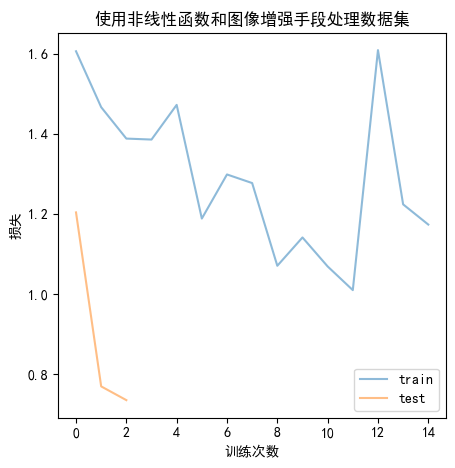

In [99]:
#定义CNN网络
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from matplotlib import pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

train_loss=list()
test_loss=list()

def plot(train_loss,test_loss):
    plt.figure(figsize=(5,5))
    plt.plot(train_loss,label='train',alpha=0.5)
    plt.plot(test_loss,label='test',alpha=0.5)
    plt.title('使用非线性函数和图像增强手段处理数据集')
    plt.xlabel('训练次数')
    plt.ylabel('损失')
    plt.legend()
    plt.show()


from torch import nn
#自定义卷积神经网络类
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), #卷积层，输入通道3，输出通道32，卷积核大小3x3，填充1
            nn.ReLU(),#激活函数ReLU
            nn.MaxPool2d(kernel_size=2, stride=2),#最大池化层，池化窗口大小2x2，步长2
            nn.BatchNorm2d(num_features=32),#批归一化层，特征数为32
            #第二层
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=64),
            #第三层
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=128),
        )

        self.fc=nn.Sequential(#定义全连接层
            nn.Flatten(),#展平操作

            nn.Linear(128*4*4,1024),#线性层，输入维度为128*4*4，输出维度为1024
            nn.ReLU(),
            nn.Dropout(),#抛弃一些神经元，提高拟合度

            nn.Linear(1024,256),
            nn.ReLU(),
            nn.Dropout(),

            nn.Linear(256,10)#十个分类
        )

    def forward(self, x):
        return self.fc(self.main(x))#前向传播过程

mynet = MyNet()
mynet=mynet.to(device)
print(mynet)

loss_fn = nn.CrossEntropyLoss()#交叉熵损失
loss_fn=loss_fn.to(device)

learning_rate=0.001
optim=torch.optim.Adam(mynet.parameters(),lr=learning_rate)


train_step=0
test_step=0
epoch=2

#主函数
if __name__=='__main__':
    for i in range(epoch):
        print(f'---------------------第{i+1}轮训练开始-----------------------')
        mynet.train()#将模型设置为训练模式
        for j, (imgs, targets) in enumerate(train_data_loader):
            imgs=imgs.to(device)
            targets=targets.to(device)

            outputs=mynet(imgs)
            loss=loss_fn(outputs,targets)
            optim.zero_grad()#梯度清零
            loss.backward()#反向传播
            optim.step()#更新权重

            train_step+=1
            if train_step%100==0:
                print(f'训练第{train_step}次，loss={loss}')
                train_loss.append(loss.item())

        #模型评估
        mynet.eval()
        accuracy=0
        accuracy_total=0
        with torch.no_grad():
            for j, (imgs, targets) in enumerate(test_data_loader):
                imgs=imgs.to(device)
                targets=targets.to(device)

                outputs=mynet(imgs)
                loss=loss_fn(outputs,targets)
                accuracy=(outputs.argmax(axis=1)==targets).sum()
                accuracy_total+=accuracy
                test_step+=1
                if test_step%100==0:
                    test_loss.append(loss.item())


            print(f'第{i+1}轮训练结束，准确率{accuracy_total/test_data_size}')
            torch.save(mynet,f'cifar10_{i+1}_acc_{accuracy_total/test_data_size}.pth')
    plot(train_loss,test_loss)#调用画图函数